## ADB: Commenti
Qui stava mischiando Tensorflow (un altro framework per deep learning) con Pytorch. Vogliamo usare SOLO pytorch, quindi ho commentato gli import di roba da Tensorflow.

Using PyTorch version: 0.4.1.post2 CUDA: False

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor



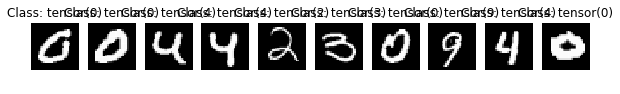

In [3]:
%matplotlib inline
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable



import math

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#import seaborn as sns

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

#torch.manual_seed(42)
#if cuda:
#    torch.cuda.manual_seed(42)


batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)


for (X_train, y_train) in train_loader:
    print ("")
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print ("")
    break
    
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

## ADB: Commenti
Qui ho modificato un po' la definizione della rete. Vogliamo estrarre i feature dai layer nascosti (fc1 e fc2). Quindi ho aggiunto metodi che fanno il forward() **solo** fino a un certo punto. Con questi metodi ora possiamo estrarre feature usando la rete addestrata (vede sotto in fondo). 

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)
    
    # Computes the forward activation up to fc1 output. The result of
    # calling this method on a batch of images will be a matrix of size
    # (batchsize, 128) where each ROW is the fc1 feature of the corresponding
    # input image from the batch.
    def extract_fc1(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return x

    # Computes the forward activation up to fc2 output.
    def extract_fc2(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        return x

    
model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


print(model)



Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## train, validation, test

In [5]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='\r')
            
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
    


In [6]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.369700
Validation set: Average loss: 0.2020, Accuracy: 9393/10000 (93%)

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.165334
Validation set: Average loss: 0.1362, Accuracy: 9589/10000 (95%)

Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.133473
Validation set: Average loss: 0.1179, Accuracy: 9646/10000 (96%)

Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.206730
Validation set: Average loss: 0.0989, Accuracy: 9701/10000 (97%)

Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.086239
Validation set: Average loss: 0.0896, Accuracy: 9716/10000 (97%)

Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.057953
Validation set: Average loss: 0.0847, Accuracy: 9741/10000 (97%)

Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.078596
Validation set: Average loss: 0.0765, Accuracy: 9773/10000 (97%)

Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.020806
Validation set: Average loss: 0.0738, Accuracy: 9778/10000 (97%)

Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.018161
Validation set: Averag

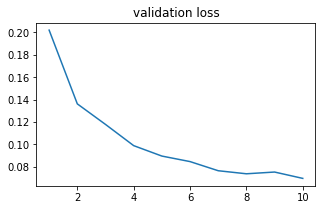

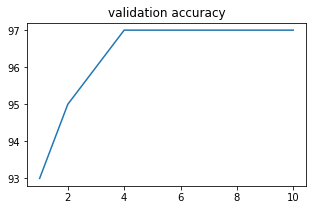

In [7]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

## ADB: Commenti
Questa funzione fa l'estrazione dei feature dalla rete ormai addestrata. Scorre il dataloader del test set e raccoglie le attivazioni fc1, fc2, e le ettichette per ogni immagine. Restituisce tre tensori con questa informazione.

In [8]:
def extract_features(loader):
    model.eval()
    fc1 = []
    fc2 = []
    labels = []
    for data, target in loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        fc1.append(model.extract_fc1(data))
        fc2.append(model.extract_fc2(data))
        labels.append(target)
    return (torch.cat(fc1), torch.cat(fc2), torch.cat(labels))

In [9]:
(fc1, fc2, labels) = extract_features(validation_loader)
print(fc1.shape)
print(fc2.shape)
print(labels.shape)

torch.Size([10000, 128])
torch.Size([10000, 128])
torch.Size([10000])


## ADB: Commenti
Allora, ora siamo pronti a analizzare questi feature. Il problema con analizzare dati di questo tipo e' la alta dimensionalita' dei dati. Gia' a 128 dimensioni e' difficile capire qualcosa. Quindi vogliamo **ridurre** la dimensionalita a 2 per poter visualizzare i feature.

Possiamo provare due strategie e poi fare un confronto:

1. Applicare una technica "semplice" tipo PCA. Vede qui come fare la PCA in scikit-learn:
    http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
2. Applicare t-SNE (obbiettivo finale). Vede quiL
    http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Per tutte e due queste tecniche, si fa la stessa procedura: si fitta il modello, poi si mappa i feature (fc1 o fc2) giu' a solo 2 dimensioni, poi si plotta tutti i punti usando un colore diverso per ogni classe (che abbiamo nel tensore label da extract_feature).

Quando abbiamo fatto queste due prove, fissiamo un ricevimento e studiamo insieme come usare Bokeh per implementare una visualizzazione piu' carina e interattiva.

# PCA

In [10]:

fc1 = fc1.detach().numpy()
fc2 = fc2.detach().numpy()
labels = labels.detach().numpy()
labels = labels.reshape(-1, 1)
pca1 = PCA(n_components=2)
pca1.fit(fc1)

pca2 = PCA(n_components=2)
pca2.fit(fc2)

print ("pca explained_variance_ratio")
print("")
print (pca1.explained_variance_ratio_)
print (pca2.explained_variance_ratio_)
print("")


print ("pca singular_values_")
print("")
print(pca1.singular_values_) 
print(pca2.singular_values_) 
print("")


fc1_pca = pca1.transform(fc1)
fc2_pca = pca2.transform(fc2)
print("pca transform and shape")
print("")
print (fc1.shape, fc1_pca.shape)
print (fc2.shape, fc2_pca.shape)
print("")

#pca3 = PCA(n_components=1)
#pca3.fit(labels)
#pca.fit(fc2)

pca explained_variance_ratio

[ 0.12180359  0.11024538]
[ 0.18868764  0.16191997]

pca singular_values_

[ 368.19238281  350.28775024]
[ 418.61895752  387.79067993]

pca transform and shape

(10000, 128) (10000, 2)
(10000, 128) (10000, 2)



## PCA with matplotlib

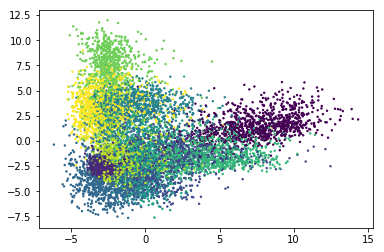

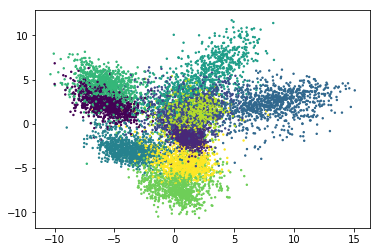

In [11]:
### This is the correct scatter plot.

plt.scatter(fc1_pca[:,0], fc1_pca[:,1], 2, labels.squeeze())
plt.figure()
plt.scatter(fc2_pca[:,0], fc2_pca[:,1], 2, labels.squeeze())

## PCA with seaborn

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

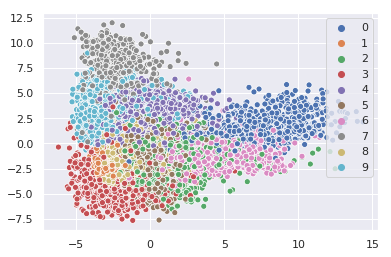

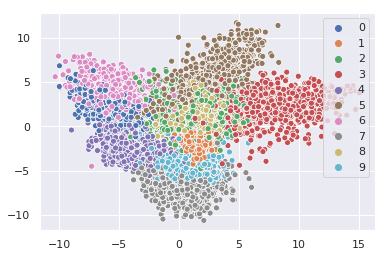

In [12]:
import seaborn as sns
sns.set(style="darkgrid")
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

labels =labels.squeeze()
#print (labels)

sns.scatterplot(x=fc1_pca[:,0],y=fc1_pca[:,1],hue=labels,legend="full",palette=sns.color_palette())
plt.figure()
sns.scatterplot(fc2_pca[:,0], fc2_pca[:,1], labels,legend="full",palette=sns.color_palette())
np.unique(labels)

# t-SNE

In [13]:
fc1_embedded = TSNE(n_components=2).fit_transform(fc1)
fc1_embedded.shape

fc2_embedded = TSNE(n_components=2).fit_transform(fc2)
fc2_embedded.shape

#labels_embedded = TSNE(n_components=2).fit_transform(labels)
#labels_embedded.shape

(10000, 2)

## t_SNE with matplotlib


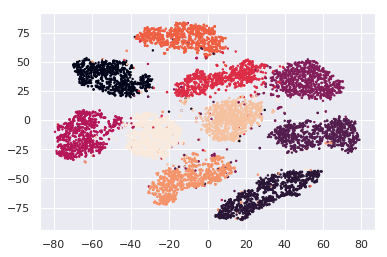

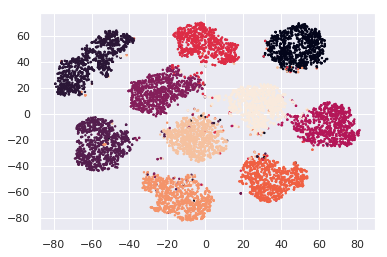

In [14]:
plt.scatter(fc1_embedded[:,0],fc1_embedded[:,1],2,labels.squeeze())
plt.figure()
plt.scatter(fc2_embedded[:,0],fc2_embedded[:,1],2,labels.squeeze())
plt.figure()

## t-SNE with seaborn

[7 2 1 ..., 4 5 6]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

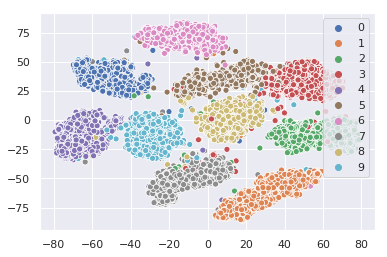

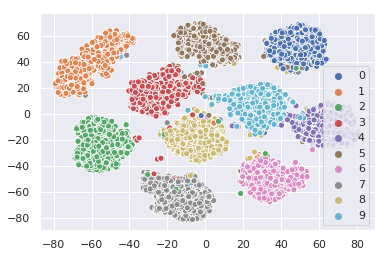

In [15]:
### This is the correct scatter plot.
import seaborn as sns; sns.set()

print (labels.squeeze())

sns.scatterplot(fc1_embedded[:,0],fc1_embedded[:,1],labels.squeeze(),legend="full",palette=sns.color_palette())
plt.figure()
sns.scatterplot(fc2_embedded[:,0], fc2_embedded[:,1], labels.squeeze(),legend="full",palette=sns.color_palette())
np.unique(labels.squeeze())

## t-SNE with bokeh


In [59]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Select
import bokeh.palettes as palettes

class Visualizer:
    def __init__(self, x, y, labels, palette='Category'):
        # Save a copy of everything.
        self.x = x
        self.y = y
        self.labels = labels
        
        # The list of available palettes.
        self.palettes = {
            'Viridis': palettes.Viridis10,
            'Magma': palettes.Magma10,
            'Category': palettes.Category10[10],
            'Plasma': palettes.Plasma10
        }
        
        # Setup the default palette and the mapping from labels to colors.
        self.default_palette = self.palettes[palette]
        self.colors = [self.default_palette[c] for c in labels]
        
        # IMPORTANT: this is how we get data into the plot, it will let us *change* the palette later.
        self.source = ColumnDataSource(data={'colors': self.colors, 'x': self.x, 'y': self.y, 'desc': labels})
        
    # This method can be passed to the Bokeh show() method to visualize the TSNE scatterplot and
    # the controls. For now, just the selector widget that allows user to select palette.
    def visualize(self, doc):
        # Make the figure and the scatterplot.
        tooltips = [('Label', '@desc')]
        p = figure(title="TSNE Visualization", toolbar_location='above', tooltips=tooltips)
        p.circle(x='x', y='y', size=5, line_color=None, fill_color='colors', alpha=1.0,
                  source=self.source)
        
        
        # Palette selection widget, plus callback.
        palette_select = Select(title="Color Palette:", options=list(self.palettes.keys()))
        palette_select.on_change('value', self.change_palette)

        # Add the selection widget plus scatterplot.
        doc.add_root(palette_select)
        doc.add_root(p)
        
    # This method changes the palette.
    def change_palette(self, attr, old, new):
        # Compute the new mapping from lab
        new_palette = self.palettes[new]
        self.colors = [new_palette[l] for l in self.labels]
        
        # The patch() method of the DataColumnSource lets us update data in plots.
        self.source.patch({'colors': [(slice(len(self.colors)), self.colors)]})


In [60]:
# Here is an example of how to use the TSNEVisualizer defined above.
output_notebook()
x = fc2_embedded[:,0]
y = fc2_embedded[:,1]
vis = Visualizer(x, y, labels.squeeze())
show(vis.visualize())

Loading BokehJS ...

TypeError: visualize() missing 1 required positional argument: 'doc'

In [61]:
# Here is an example of how to use the TSNEVisualizer defined above.
output_notebook()
x = fc2_pca[:,0]
y = fc2_pca[:,1]
vis = Visualizer(x, y, labels.squeeze())
show(vis.visualize())

Loading BokehJS ...

TypeError: visualize() missing 1 required positional argument: 'doc'